In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/root/autodl-tmp/miniconda3/envs/cypytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 3407
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_outputs):
        # 计算注意力权重
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_weights = self.softmax(torch.matmul(energy, self.v.unsqueeze(1)).squeeze(2))
        # 对编码器输出进行加权求和
        context_vector = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=1)

        return context_vector

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        self.load_data = data[:,0,0].reshape(-1, 1)
        self.weather_time_data = data[:,0,1:]
        self.seq_length = seq_length
        self.pred_length = pred_length
        

    def __len__(self):
        return len(self.load_data) - self.seq_length - self.pred_length

    def __getitem__(self, index):
        # x为负荷数据和天气时间数据的拼接，y为负荷数据
        x_load = self.load_data[index:index + self.seq_length]
        x_weather_time = self.weather_time_data[index:index + self.seq_length]
        # print(x_load.shape, x_weather_time.shape)
        x_combined = np.concatenate([x_load, x_weather_time], axis=1)
        y = self.load_data[index + self.seq_length:index + self.seq_length + self.pred_length]
        y = y.reshape(-1)
        return x_combined, y



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         attention_output = self.attention(out)
        
#         out = self.fc(attention_output)
        return out


def normalize_data(df):
    df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return df

# 读取训练集和验证集的数据
df = pd.read_csv('data/Area1_Load_Weather_Time.csv')
# Avg_Temperature  Avg_Humidity Rainfall缺失值用前一个值填充
df['Avg_Temperature'] = df['Avg_Temperature'].fillna(method='ffill')
df['Avg_Humidity'] = df['Avg_Humidity'].fillna(method='ffill')
df['Rainfall'] = df['Rainfall'].fillna(method='ffill')
df = df[df['Time'] <= '2015-01-11']
df = df.drop('Time', axis=1)

# 选取训练集和验证集的数据
# df = normalize_data(df)
# print(df.describe())
m_all = len(df) # 数据集总行数
m_val = 52*96 # 验证集数量
m_test = 52*96 # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量

train_df = df.iloc[:m_train]
val_df = df.iloc[m_train:m_train+m_val]
test_df = df.iloc[m_train+m_val:]


scaler = StandardScaler()
# 用训练集的数据计算均值和方差
scaler.fit(train_df)
train_df = scaler.transform(train_df)
# 对验证集和测试集进行相同的归一化操作
val_df = scaler.transform(val_df)

test_df_origin = test_df
test_df = scaler.transform(test_df)
print(train_df.shape, val_df.shape, test_df.shape)

(16560, 9) (4992, 9) (4992, 9)


(672, 9) torch.Size([96])
Epoch 1/20, Train Loss: 0.5385, Val Loss: 0.3485
Epoch 2/20, Train Loss: 0.2338, Val Loss: 0.2691
Epoch 3/20, Train Loss: 0.1673, Val Loss: 0.2146
Epoch 4/20, Train Loss: 0.1270, Val Loss: 0.1894
Epoch 5/20, Train Loss: 0.1068, Val Loss: 0.1721
Epoch 6/20, Train Loss: 0.0885, Val Loss: 0.1626
Epoch 7/20, Train Loss: 0.0749, Val Loss: 0.1704
Epoch 8/20, Train Loss: 0.0991, Val Loss: 0.2469
Epoch 9/20, Train Loss: 0.1112, Val Loss: 0.2143
Epoch 10/20, Train Loss: 0.0893, Val Loss: 0.1980
Epoch 11/20, Train Loss: 0.0647, Val Loss: 0.1900
Epoch 12/20, Train Loss: 0.0560, Val Loss: 0.1957
Epoch 13/20, Train Loss: 0.0511, Val Loss: 0.1993
Epoch 14/20, Train Loss: 0.0471, Val Loss: 0.2005
Epoch 15/20, Train Loss: 0.0590, Val Loss: 0.2456
Epoch 16/20, Train Loss: 0.0924, Val Loss: 0.1949
Epoch 17/20, Train Loss: 0.0616, Val Loss: 0.2079
Epoch 18/20, Train Loss: 0.0491, Val Loss: 0.2153
Epoch 19/20, Train Loss: 0.0420, Val Loss: 0.2105
Epoch 20/20, Train Loss: 0.0377, 

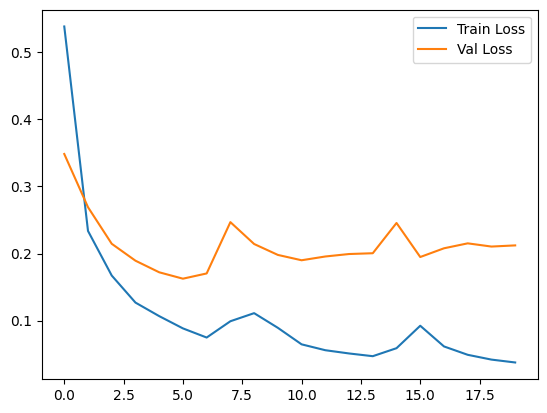

In [5]:
# 将数据集转换为PyTorch的Tensor
train_data = torch.tensor(train_df, dtype=torch.float32).unsqueeze(1)
val_data = torch.tensor(val_df, dtype=torch.float32).unsqueeze(1)

# 创建训练集和验证集的数据集对象
# 选取合适的seq_length和pred_length
# seq_length是用来预测的历史数据长度，pred_length是预测的未来数据长度
seq_length = 96*7
pred_length = 96
train_dataset = TimeSeriesDataset(train_data, seq_length,pred_length)
val_dataset = TimeSeriesDataset(val_data, seq_length,pred_length)
# 查看第一个数据
x, y = train_dataset[0]
print(x.shape, y.shape)
# 创建数据加载器
# 选取合适的batch_size,要保证batch_size整除数据集大小
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义模型参数
input_size = 9 # 负荷数据和天气时间数据的维度
hidden_size = 64
num_layers = 2
output_size = 96 # 预测未来96个时间步的负荷数据

# 创建模型实例
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到训练设备
model.to(device)

# 定义训练参数
""" 在这里改变学习率和训练次数 """
num_epochs = 20
# learning_rate = 0.001
learning_rate = 0.01

# 定义损失函数和优化器

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 初始化最好的验证集损失
best_val_loss = float('inf')

# 记录train_loss和val_loss
train_loss_list = []
val_loss_list = []

# 记录预测值和真实值
predictions_train = []
# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # print(len(train_dataloader))
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    # 在验证集上进行评估
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_loss_list.append(val_loss)
    # 每隔10次打印训练结果，想要每次都打印可以把10改为1
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 保存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pt')

print(f'Best Val Loss: {best_val_loss:.4f}')
# 画出train_loss和val_loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.show()

In [6]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# 将数据集转换为PyTorch的Tensor
test_data = torch.tensor(test_df, dtype=torch.float32).unsqueeze(1)

# 创建测试集的数据集对象
# 选取合适的seq_length和pred_length
# seq_length是用来预测的历史数据长度，pred_length是预测的未来数据长度
seq_length = 96*7
pred_length = 96
test_dataset = TimeSeriesDataset(test_data, seq_length, pred_length)

# 创建数据加载器
# 选取合适的batch_size,要保证batch_size整除数据集大小
batch_size = 96
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 加载已训练好的模型参数
model.load_state_dict(torch.load('best_model_1.pt'))
model.to(device)
model.eval()


# 在测试集上进行预测
predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        predictions.append(outputs.detach().cpu().numpy())

# 创建真实值数据集
def create_targets(data, seq_length, pred_length):
    m = len(data) - seq_length - pred_length
    targets = np.zeros((m, pred_length))
    for i in range(m):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + pred_length]
        targets[i] = y
    return targets
test_true = create_targets(test_df_origin['Load'].values, seq_length, pred_length)

# 将预测结果转换为pred_length维数组
predictions = np.concatenate(predictions, axis=0)
predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1),np.zeros((405504,8))),axis=1))[:,0].reshape(-1,96)

(4224, 96)
(4224, 96)


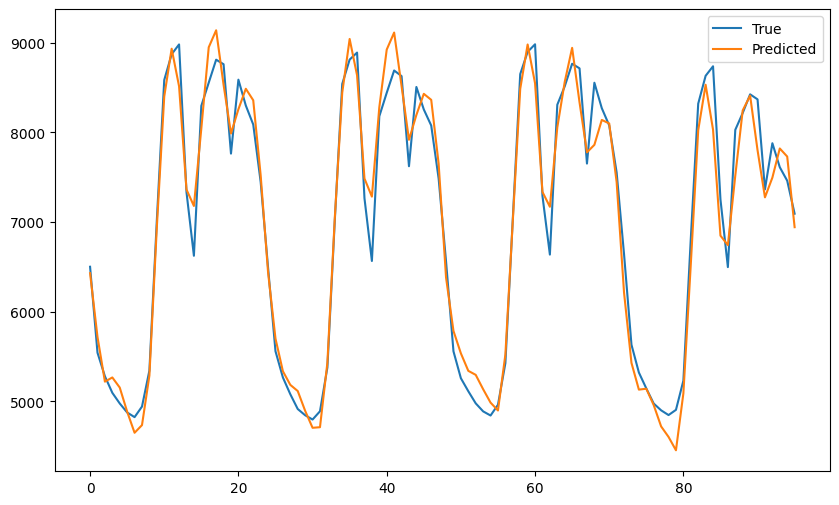

In [7]:
# predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1),np.zeros((predictions.shape[0],8))),axis=1))[:,0]
print(predictions.shape)
print(test_true.shape)
# 画出预测结果
plt.figure(figsize=(10, 6))
# 选择天数
n = 4223
plt.plot(test_true[n], label='True')
plt.plot(predictions[n], label='Predicted')
plt.legend()
plt.show()

(405504,)
(405504,)


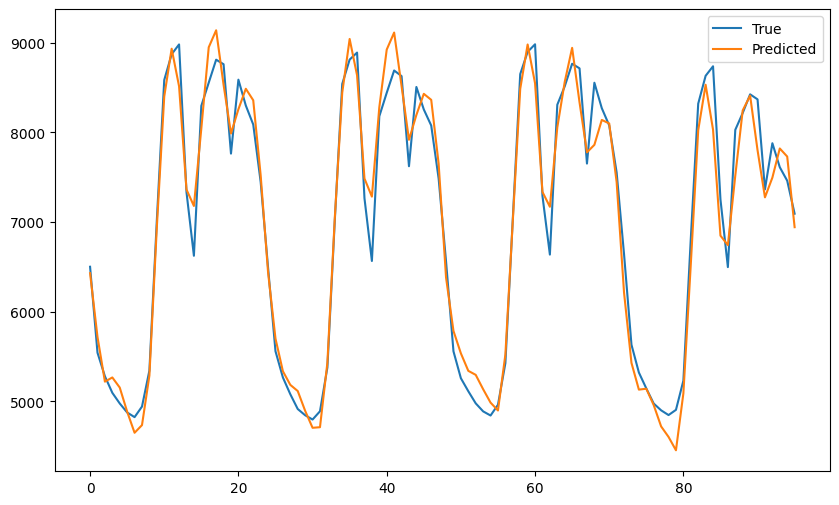

In [8]:
test_true = test_true.flatten()
# 将预测结果转换为pred_length维数组
predictions = predictions.flatten()
print(predictions.shape)
print(test_true.shape)
# 画出预测结果
plt.figure(figsize=(10, 6))
plt.plot(test_true[-96:], label='True')
plt.plot(predictions[-96:], label='Predicted')
plt.legend()
plt.show()

In [9]:
# 计算RMSE
# 计算 MAE
mae = mean_absolute_error(test_true, predictions)
print(f'MAE: {mae:.2f}')
rmse = sqrt(mean_squared_error(test_true, predictions))
print(f'RMSE: {rmse:.2f}')
# 计算MAPE
mape = mean_absolute_percentage_error(test_true, predictions)*100
print(f'MAPE: {mape:.2f}%')
# 计算 R²
r2 = r2_score(test_true, predictions)
print(f'R²: {r2:.2f}')


MAE: 645.90
RMSE: 934.03
MAPE: 9.05%
R²: 0.78
